In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .config("spark.sql.broadcastTimeout", "1000") \
    .config("spark.driver.maxResultSize", '10g') \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors


%matplotlib inline

In [3]:
#Define preprocessing pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

# load pre-processed table

In [4]:
clean_df = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")

In [5]:
clean_df.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|       0.0|        1.0|        5.0|         0.0|
|file:/project/ds5...|[0.0, 0.0, 0.

# load PCA model

In [6]:
pca_path = "/project/ds5559/BioNerds/PCA/pcaModel_50"

In [7]:
%%time
from pyspark.ml.feature import PCAModel
pcaModel_50 = PCAModel.load(pca_path)

CPU times: user 2.64 ms, sys: 1.91 ms, total: 4.55 ms
Wall time: 1.72 s


In [8]:
%%time 
pca_table = pcaModel_50.transform(clean_df)

CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 112 ms


In [9]:
pca_table.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|         pcaFeatures|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|[71.8275654736491...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|

In [10]:
pca_table.cache()

DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

# Model using PCA top 50
## assemble features. 

In [11]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import OneVsRest

#Define preprocessing pipeline

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'pcaFeatures'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')


gbt = GBTClassifier(labelCol="indexed_dx", featuresCol="Feature_vec", maxIter=10, maxDepth=5, maxBins=32)
ovr  = OneVsRest(classifier=gbt,  featuresCol='Feature_vec', labelCol='indexed_dx')

In [22]:
model_pipe = Pipeline(stages = [ OH, vec_assemb, ovr])

In [13]:
# save dataframe
# transformed_table.write.save("/project/ds5559/BioNerds/saved_data/transformed_table.parquet")

# split transformed_table to training set and test set by dx. 
# using stratified split by ratio 0.8:0.2

In [14]:
pca_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [15]:
fractions = pca_table.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [16]:
training_set = pca_table.stat.sampleBy("dx",fractions, seed=314)

In [17]:
%%time
training_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_set.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  411|
|  mel|       1.0|  890|
|   nv|       0.0| 5336|
|  bkl|       2.0|  865|
|   df|       6.0|   95|
| vasc|       5.0|  111|
|akiec|       4.0|  272|
+-----+----------+-----+

CPU times: user 1.42 ms, sys: 1.54 ms, total: 2.96 ms
Wall time: 4.16 s


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

In [18]:
%%time
test_set = pca_table.subtract(training_set)
test_set.cache()

CPU times: user 460 µs, sys: 1.35 ms, total: 1.81 ms
Wall time: 112 ms


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

In [19]:
%%time
test_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  103|
|  mel|       1.0|  221|
|   nv|       0.0| 1314|
|  bkl|       2.0|  224|
|   df|       6.0|   20|
| vasc|       5.0|   31|
|akiec|       4.0|   55|
+-----+----------+-----+

CPU times: user 7.81 ms, sys: 3.77 ms, total: 11.6 ms
Wall time: 1min 12s


In [20]:
test_set.cache()

DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

# fit GBT Model

### Model with age, sex, localization, age, dx_type

In [23]:
%%time
model = model_pipe.fit(training_set)

CPU times: user 231 ms, sys: 65 ms, total: 296 ms
Wall time: 3min 16s


In [24]:
%%time
predictions =model.transform(test_set)


CPU times: user 80.8 ms, sys: 28.1 ms, total: 109 ms
Wall time: 593 ms


In [25]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 31.7 ms, sys: 3.55 ms, total: 35.3 ms
Wall time: 16.9 s


0.7003430634440264

In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

In [27]:
predictionAndLabels.show(5)

+----------+----------+
|prediction|indexed_dx|
+----------+----------+
|       2.0|       2.0|
|       0.0|       0.0|
|       1.0|       1.0|
|       0.0|       0.0|
|       0.0|       0.0|
+----------+----------+
only showing top 5 rows



In [28]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1.258e+03, 1.600e+01, 3.500e+01, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00],
       [1.230e+02, 5.500e+01, 2.700e+01, 1.000e+01, 4.000e+00, 1.000e+00,
        1.000e+00],
       [9.200e+01, 2.300e+01, 9.000e+01, 1.100e+01, 6.000e+00, 1.000e+00,
        1.000e+00],
       [2.700e+01, 1.000e+01, 1.900e+01, 3.700e+01, 1.000e+01, 0.000e+00,
        0.000e+00],
       [1.800e+01, 1.000e+00, 2.100e+01, 6.000e+00, 8.000e+00, 0.000e+00,
        1.000e+00],
       [2.100e+01, 3.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.400e+01, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]])

### confusion matrix

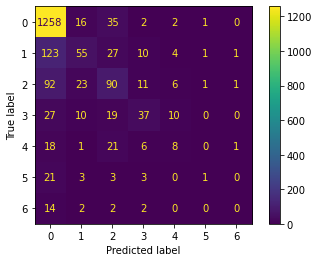

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

### accuracy

In [30]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

accuracy: 0.7362804878048781
precision: 0.6876661461826228
recall: 0.7362804878048781
fMeasure: 0.7003430634440264


### Statistics by class

In [31]:
labels = predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
df = pd.DataFrame()
for label in sorted(labels):
    df = df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
df

,class,f1,precision,recall
0,0.0,0.877572,0.810045,0.957382
1,1.0,0.332326,0.500000,0.248869
2,2.0,0.427553,0.456853,0.401786
3,3.0,0.425287,0.521127,0.359223
4,4.0,0.188235,0.266667,0.145455
5,5.0,0.057143,0.250000,0.032258
6,6.0,0.000000,0.000000,0.000000


# Cross Validation (5 fold) and Tuning hyperparameters

In [32]:
### cross valication

#%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15]) # Max Depth of trees
             .addGrid(gbt.maxBins, [8,16 ,32]) # Max binning for numeric features
             .build())

In [33]:
%%time
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=model_pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4, \
                    seed = 314)

CPU times: user 353 µs, sys: 0 ns, total: 353 µs
Wall time: 345 µs


In [34]:
%%time
cvModel = cv.fit(training_set)

CPU times: user 1min 32s, sys: 28.5 s, total: 2min
Wall time: 3h 14min 22s


In [35]:
cvModel.save("GBT_pca")

In [36]:
%%time
cv_predictions = cvModel.transform(test_set)

CPU times: user 90 ms, sys: 35.8 ms, total: 126 ms
Wall time: 518 ms


In [37]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 161 ms, sys: 67.1 ms, total: 228 ms
Wall time: 13.1 s


0.7018638634759664

In [38]:
bestModel = cvModel.bestModel

In [81]:
print ('Best Param (MaxBins): ', bestModel.stages[2].getClassifier().getMaxBins())
print ('Best Param (MaxDepth): ', bestModel.stages[2].getClassifier().getMaxDepth())
print ('Best Param (MaxIter): ', bestModel.stages[2].getClassifier().getMaxIter())

Best Param (MaxBins):  16
Best Param (MaxDepth):  5
Best Param (MaxIter):  10


In [39]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
cv_metrics.confusionMatrix().toArray()

array([[1.259e+03, 2.100e+01, 2.500e+01, 4.000e+00, 2.000e+00, 0.000e+00,
        3.000e+00],
       [1.240e+02, 5.000e+01, 3.000e+01, 1.100e+01, 5.000e+00, 0.000e+00,
        1.000e+00],
       [9.500e+01, 2.300e+01, 8.600e+01, 1.300e+01, 5.000e+00, 1.000e+00,
        1.000e+00],
       [2.300e+01, 8.000e+00, 2.500e+01, 4.000e+01, 4.000e+00, 1.000e+00,
        2.000e+00],
       [1.600e+01, 4.000e+00, 1.700e+01, 7.000e+00, 9.000e+00, 0.000e+00,
        2.000e+00],
       [2.000e+01, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 5.000e+00,
        0.000e+00],
       [1.400e+01, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00]])

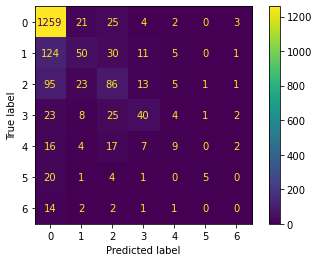

In [40]:
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

#### accuracy, precision, recall, fMeasure

In [41]:
print("accuracy: {}".format(cv_metrics.accuracy))
print("precision: {}".format(cv_metrics.weightedPrecision))
print("recall: {}".format(cv_metrics.weightedRecall))
print("fMeasure: {}".format(cv_metrics.weightedFMeasure()))

accuracy: 0.7362804878048781
precision: 0.6933988010240352
recall: 0.736280487804878
fMeasure: 0.7018638634759664


### Statistics by class

In [42]:
labels = cv_predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":cv_metrics.precision(label),
               "recall":cv_metrics.recall(label),
               "f1":cv_metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.878883,0.811734,0.958143
1,1.0,0.303030,0.458716,0.226244
2,2.0,0.416465,0.455026,0.383929
3,3.0,0.444444,0.519481,0.388350
4,4.0,0.222222,0.346154,0.163636
5,5.0,0.263158,0.714286,0.161290
6,6.0,0.000000,0.000000,0.000000


# RandonForest, newly trained TL model,

In [44]:
RN50_df = spark.read.load("/project/ds5559/BioNerds/saved_data/ResNet50_indexed.parquet")

### split transformed_table to training set and test set by dx.
### using stratified split by ratio 0.8:0.2

In [45]:
RN50_df.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [46]:
fractions = RN50_df.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [47]:
training_RN50 = RN50_df.stat.sampleBy("dx",fractions, seed=314)

In [48]:
%%time
training_RN50.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_RN50.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  399|
|  mel|       1.0|  888|
|   nv|       0.0| 5333|
|  bkl|       2.0|  874|
|   df|       6.0|   89|
| vasc|       5.0|  114|
|akiec|       4.0|  257|
+-----+----------+-----+

CPU times: user 6.46 ms, sys: 231 µs, total: 6.69 ms
Wall time: 273 ms


DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [49]:
%%time
test_RN50 = RN50_df.subtract(training_RN50)
test_RN50.cache()

CPU times: user 0 ns, sys: 2.81 ms, total: 2.81 ms
Wall time: 64.1 ms


DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [50]:
%%time
test_RN50.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  115|
|  mel|       1.0|  223|
|   nv|       0.0| 1317|
|  bkl|       2.0|  215|
|   df|       6.0|   26|
| vasc|       5.0|   28|
|akiec|       4.0|   70|
+-----+----------+-----+

CPU times: user 66 ms, sys: 34.2 ms, total: 100 ms
Wall time: 6.26 s


# Traing the GBT

In [51]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import OneVsRest

#Define preprocessing pipeline

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'features_2'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')


gbt = GBTClassifier(labelCol="indexed_dx", featuresCol="Feature_vec", maxIter=10, maxDepth=5, maxBins=32)
ovr  = OneVsRest(classifier=gbt,  featuresCol='Feature_vec', labelCol='indexed_dx')

In [52]:
modelTL_pipe = Pipeline(stages = [ OH, vec_assemb, ovr])

In [53]:
model_rf = modelTL_pipe.fit(training_RN50)

In [54]:
%%time
predictions =model_rf.transform(test_RN50)

CPU times: user 83.6 ms, sys: 32.9 ms, total: 117 ms
Wall time: 530 ms


In [55]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 119 ms, sys: 52.7 ms, total: 171 ms
Wall time: 9.78 s


0.776046309596976

In [56]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

In [57]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1.245e+03, 3.000e+01, 3.300e+01, 8.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00],
       [8.000e+01, 9.900e+01, 3.500e+01, 4.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00],
       [5.200e+01, 2.400e+01, 1.210e+02, 8.000e+00, 9.000e+00, 0.000e+00,
        1.000e+00],
       [2.400e+01, 1.200e+01, 1.300e+01, 5.800e+01, 6.000e+00, 1.000e+00,
        1.000e+00],
       [1.200e+01, 7.000e+00, 1.800e+01, 1.000e+01, 2.300e+01, 0.000e+00,
        0.000e+00],
       [8.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.700e+01,
        0.000e+00],
       [1.100e+01, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        8.000e+00]])

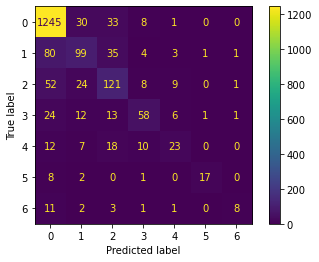

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [59]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

accuracy: 0.7878635907723169
precision: 0.7736353284804095
recall: 0.787863590772317
fMeasure: 0.776046309596976


In [60]:
labels = predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
df = pd.DataFrame()
for label in sorted(labels):
    df = df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
df

,class,f1,precision,recall
0,0.0,0.905784,0.869413,0.945330
1,1.0,0.496241,0.562500,0.443946
2,2.0,0.552511,0.542601,0.562791
3,3.0,0.565854,0.644444,0.504348
4,4.0,0.407080,0.534884,0.328571
5,5.0,0.723404,0.894737,0.607143
6,6.0,0.432432,0.727273,0.307692


# Cross Validation (5 fold) and Tuning hyperparameters

In [61]:
### cross valication

#%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15]) # Max Depth of trees
             .addGrid(gbt.maxBins, [8,16 ,32]) # Max binning for numeric features
             .build())

In [62]:
%%time
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=modelTL_pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4, \
                    seed = 314 )

CPU times: user 375 µs, sys: 0 ns, total: 375 µs
Wall time: 347 µs


In [63]:
%%time
cvModel = cv.fit(training_RN50)

CPU times: user 1min 27s, sys: 36.2 s, total: 2min 3s
Wall time: 1h 32min 55s


In [64]:
cvModel.save("GBT_RN50")

In [65]:
%%time
cv_predictions = cvModel.transform(test_RN50)

CPU times: user 92.2 ms, sys: 40.5 ms, total: 133 ms
Wall time: 530 ms


In [66]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 189 ms, sys: 84.1 ms, total: 273 ms
Wall time: 9.68 s


0.776046309596976

In [67]:
bestModel_2 = cvModel.bestModel

In [82]:
print ('Best Param (MaxBins): ', bestModel_2.stages[2].getClassifier().getMaxBins())
print ('Best Param (MaxDepth): ', bestModel_2.stages[2].getClassifier().getMaxDepth())
print ('Best Param (MaxIter): ', bestModel_2.stages[2].getClassifier().getMaxIter())

Best Param (MaxBins):  32
Best Param (MaxDepth):  5
Best Param (MaxIter):  10


In [68]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
cv_metrics.confusionMatrix().toArray()

array([[1.245e+03, 3.000e+01, 3.300e+01, 8.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00],
       [8.000e+01, 9.900e+01, 3.500e+01, 4.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00],
       [5.200e+01, 2.400e+01, 1.210e+02, 8.000e+00, 9.000e+00, 0.000e+00,
        1.000e+00],
       [2.400e+01, 1.200e+01, 1.300e+01, 5.800e+01, 6.000e+00, 1.000e+00,
        1.000e+00],
       [1.200e+01, 7.000e+00, 1.800e+01, 1.000e+01, 2.300e+01, 0.000e+00,
        0.000e+00],
       [8.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.700e+01,
        0.000e+00],
       [1.100e+01, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        8.000e+00]])

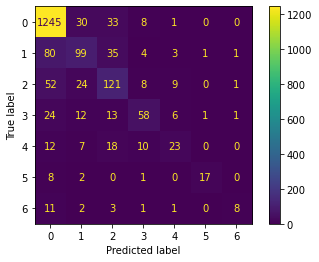

In [69]:
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

In [70]:
print("accuracy: {}".format(cv_metrics.accuracy))
print("precision: {}".format(cv_metrics.weightedPrecision))
print("recall: {}".format(cv_metrics.weightedRecall))
print("fMeasure: {}".format(cv_metrics.weightedFMeasure()))

accuracy: 0.7878635907723169
precision: 0.7736353284804095
recall: 0.787863590772317
fMeasure: 0.776046309596976


In [71]:
labels = cv_predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":cv_metrics.precision(label),
               "recall":cv_metrics.recall(label),
               "f1":cv_metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.905784,0.869413,0.945330
1,1.0,0.496241,0.562500,0.443946
2,2.0,0.552511,0.542601,0.562791
3,3.0,0.565854,0.644444,0.504348
4,4.0,0.407080,0.534884,0.328571
5,5.0,0.723404,0.894737,0.607143
6,6.0,0.432432,0.727273,0.307692
